# Function

In [1]:
import torch
import torch.nn as nn
from torchvision import models
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.transforms.functional as TF
import random
import h5py
import glob, os, time
import numpy as np
import torch.optim as optim
from torch.optim.lr_scheduler import MultiStepLR
import logging
from PIL import Image
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Model

In [2]:
class CSRNet(nn.Module):
    def __init__(self, load_weights=False):
        super(CSRNet, self).__init__()
        self.seen = 0
        self.frontend_feat = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512]
        self.backend_feat  = [512, 512, 512,256,128,64]
        self.frontend = make_layers(self.frontend_feat)
        self.backend = make_layers(self.backend_feat,in_channels = 512,dilation = True)
        self.output_layer = nn.Conv2d(64, 1, kernel_size=1)
        
        if not load_weights:
            mod = models.vgg16(pretrained = True)
            self._initialize_weights()
            
            # orderdict to list
            weight = [lay[1] for lay in mod.state_dict().items()]
            # apply
            for i, layer in enumerate(self.frontend.state_dict().items()):
                layer[1].data[:] = weight[i].data[:]
                
    def forward(self,x):
        x = self.frontend(x)
        x = self.backend(x)
        x = self.output_layer(x)
        return x
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, std=0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            
                
def make_layers(cfg, in_channels = 3,batch_norm=False,dilation = False):
    if dilation:
        d_rate = 2
    else:
        d_rate = 1
    layers = []
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=d_rate,dilation = d_rate)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)                

In [3]:
# model = CSRNet()
# model(torch.FloatTensor(5,3,128,128).zero_()).shape

## Dataset

### augments

In [4]:
class RandomResizedCrop:
    def __init__(self, size, scale):
        self.transform = transforms.RandomResizedCrop(size = size, scale= scale)
        
    def __call__(self, img, hot_map0, hot_map1):
        crop_indices = self.transform.get_params(img, \
                                                 scale = self.transform.scale, \
                                                 ratio = self.transform.ratio)
        i, j, h, w = crop_indices
        return TF.resized_crop(img, i, j, h, w, self.transform.size, self.transform.interpolation),\
                TF.resized_crop(hot_map0, i, j, h, w, self.transform.size, self.transform.interpolation),\
                TF.resized_crop(hot_map1, i, j, h, w, self.transform.size, self.transform.interpolation)

class RandomRotation:
    def __init__(self, max_angle = 90):
        self.max_angle = max_angle
        
    def __call__(self, img, hot_map):
        angle = random.random() * self.max_angle
        return TF.rotate(img, angle), TF.rotate(hot_map, angle)
    
class RandomVFlip:
    def __init__(self):
        pass
    def __call__(self, img, hot_map0, hot_map1):
        return TF.vflip(img), TF.vflip(hot_map0), TF.vflip(hot_map1)

class RandomHFlip:
    def __init__(self):
        pass
    def __call__(self, img, hot_map0, hot_map1):
        return TF.hflip(img), TF.hflip(hot_map0), TF.hflip(hot_map1)

class FixTransforms:
    # apply the same augmentations on both input and gt
    def __init__(self, augmentations, probs):
        self.augmentations = augmentations
        self.probs = probs

    def __call__(self, img, hot_map0, hot_map1):
        # both img, hot_map are PIL
        for i, augmentation in enumerate(self.augmentations):
            if random.random() < self.probs[i]:
                img, hot_map0, hot_map1 = augmentation(img, hot_map0, hot_map1)
        return img, hot_map0, hot_map1

### dataset

In [5]:
class SDD(Dataset):
    def __init__(self, size = 512):
        super(SDD, self).__init__()
        self.file_list = glob.glob('data/raw_v3/*.h5')
        
        self.transform = transforms.Compose([
            transforms.ToTensor(),\
#             transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                                      std=[0.229, 0.224, 0.225]),
        ])

        self.aug = FixTransforms([
            RandomHFlip(),
            RandomVFlip(),
#             RandomRotation(),
            RandomResizedCrop(size = size, scale=(0.7, 1.0)),
#         ],probs = [0,0,0,0])
        ], probs = [0.5, 0.5, 1, 1])
        

    def __getitem__(self, index):
        data = h5py.File(self.file_list[index], 'r')
        xs, ys0, ys1 = np.asarray(data['img']), np.asarray(data['map0']), np.asarray(data['map1'])
        
        xs = TF.to_pil_image(xs)
        ys0 = TF.to_pil_image(ys0)
        ys1 = TF.to_pil_image(ys1)
        
        xs, ys0, ys1 = self.aug(xs, ys0, ys1)
        
        xs = self.transform(xs)
        
        ys0 = TF.resize(ys0, [int(ys0.size[1]/8), int(ys0.size[0]/8)])
        ys0 = TF.to_tensor(ys0)
        ys1 = TF.resize(ys1, [int(ys1.size[1]/8), int(ys1.size[0]/8)])
        ys1 = TF.to_tensor(ys1)

        return xs, ys0, ys1

    def __len__(self):
        return len(self.file_list)
    
class ValSDD(Dataset):
    def __init__(self):
        super(ValSDD, self).__init__()
        self.file_list = glob.glob('data/val/*.h5')
        
        self.transform = transforms.Compose([
            transforms.ToTensor(),\
#             transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                                      std=[0.229, 0.224, 0.225]),
        ])

    def __getitem__(self, index):
        data = h5py.File(self.file_list[index], 'r')
        xs, ys0, ys1 = np.asarray(data['img']), np.asarray(data['map0']), np.asarray(data['map1'])
        
        xs = TF.to_pil_image(xs)
        ys0 = TF.to_pil_image(ys0)
        ys1 = TF.to_pil_image(ys1)
        
        xs = self.transform(xs)
        ys0 = TF.resize(ys0, [int(ys0.size[1]/8), int(ys0.size[0]/8)])
        ys0 = TF.to_tensor(ys0)
        ys1 = TF.resize(ys1, [int(ys1.size[1]/8), int(ys1.size[0]/8)])
        ys1 = TF.to_tensor(ys1)
        return xs, ys0, ys1

    def __len__(self):
        return len(self.file_list)
    
class TestData(Dataset):
    def __init__(self):
        super(TestData, self).__init__()
        self.file_list = glob.glob('data/test/*.png')
        
        self.transform = transforms.Compose([
            transforms.ToTensor(),\
#             transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                                      std=[0.229, 0.224, 0.225]),
        ])

    def __getitem__(self, index):
        xs = Image.open(self.file_list[index]).convert('RGB')
        xs = self.transform(xs)
        return xs

    def __len__(self):
        return len(self.file_list)

## eval func

In [6]:
def evalfunc(model, VLoader, criterion, scaling_factor):
    model.eval()
    loss, count = 0, 0
    with torch.no_grad():
        for n_count, (x, y0, y1) in enumerate(VLoader):
            output = model(x.to(device))
#             loss += criterion(output, y0.to(device) * scaling_factor)
            loss += criterion(output, y1.to(device) * scaling_factor).item() * x.shape[0]
            count += 1
    model.train()
    return loss/count
    

## test

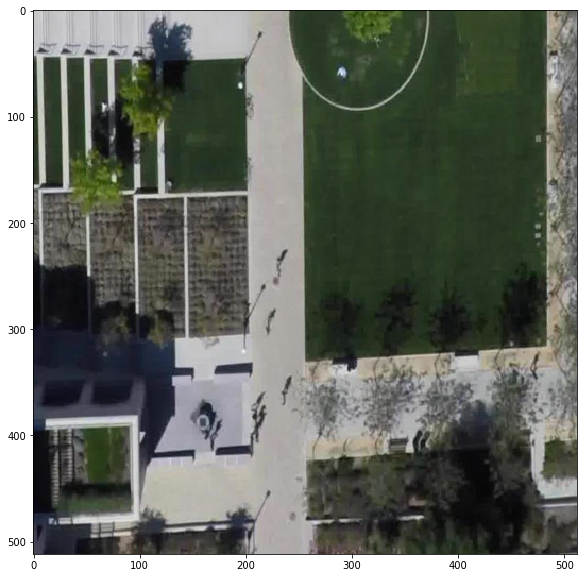

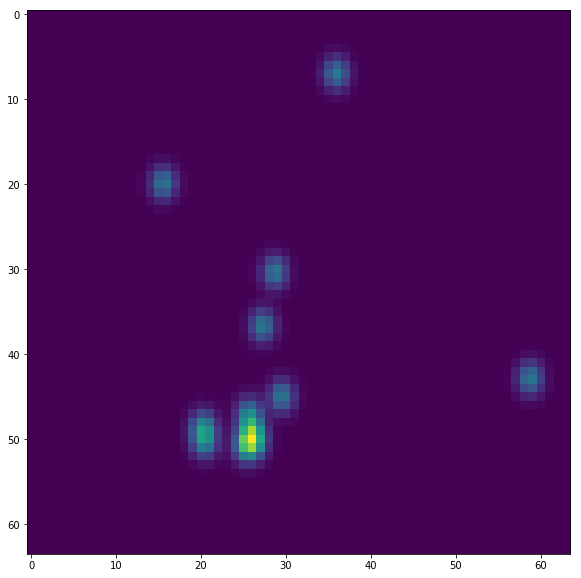

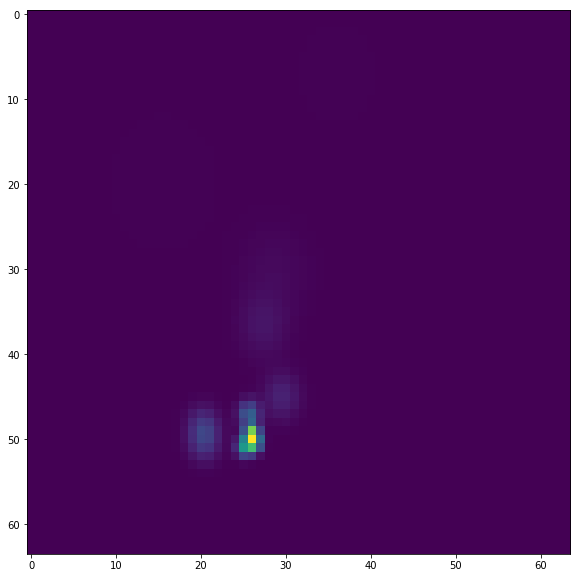

In [61]:
d = SDD(size = 512)
DLoader = DataLoader(dataset = d, num_workers = 4, batch_size = 1, shuffle = True)
for n_count, (x, y0, y1) in enumerate(DLoader):
    break
plt.figure(figsize=(10,10))
plt.imshow(x[0].permute(1,2,0).numpy())
plt.clim(0,1)
plt.figure(figsize=(10,10))
plt.imshow(y0[0,0].numpy()*1e6)
plt.figure(figsize=(10,10))
plt.imshow(y1[0,0].numpy()*1e6)

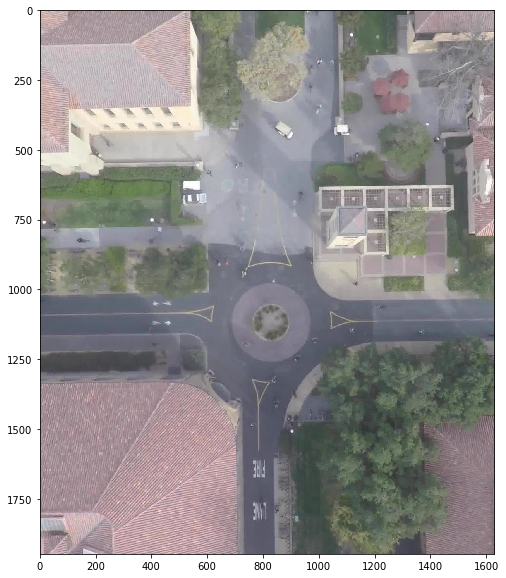

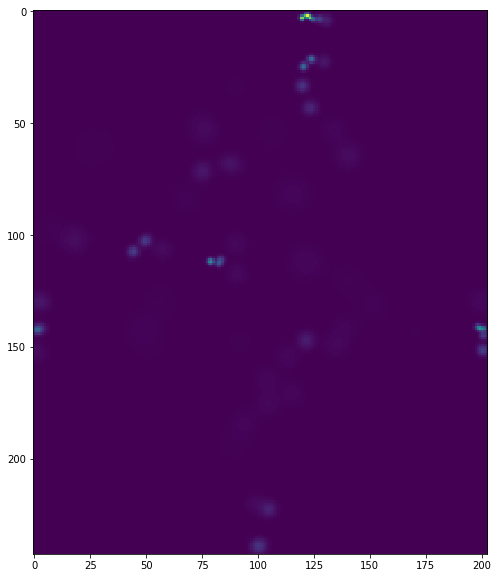

In [56]:
d = ValSDD()
DLoader = DataLoader(dataset = d, num_workers = 1, batch_size = 1, shuffle = True)
for n_count, (x, y) in enumerate(DLoader):
    break
plt.figure(figsize=(10,10))
plt.imshow(x[0].permute(1,2,0).numpy())
plt.clim(0,1)
plt.figure(figsize=(10,10))
plt.imshow(y[0,0].numpy()*1e6)

# Main

In [7]:
n_epoch = 20
batch_size = 16
scaling_factor = 1e5
lr = 1e-5

# model dir
save_dir = 'model/trial4_1/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# logger
logger = logging.getLogger()
hdlr = logging.FileHandler(os.path.join(save_dir, 'train.log'))
formatter = logging.Formatter('%(asctime)s %(levelname)s %(message)s')
hdlr.setFormatter(formatter)
logger.addHandler(hdlr) 
logger.setLevel(logging.INFO)

# model
model = CSRNet().to(device)
model.train()

# dataset
d = SDD(size = 512)
DLoader = DataLoader(dataset = d, num_workers = 4, batch_size = batch_size, shuffle = True)
v = ValSDD()
VLoader = DataLoader(dataset = v, num_workers = 1, batch_size = 1, shuffle = False)

# criterion
criterion = nn.MSELoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
# scheduler
scheduler = MultiStepLR(optimizer, milestones=[5,15,25], gamma=0.5)

init_epoch = 0
# init_epoch = findLastCheckpoint(save_dir=save_dir)  # load the last model in matconvnet style
# if init_epoch > 0:
#     print('resuming by loading epoch %03d' % init_epoch)
#     model.load_state_dict(\
#                 torch.load(os.path.join(save_dir, 'model_%03d.pth' % init_epoch))['stat_dict']\
#                           )
#     optimizer.load_state_dict(\
#                 torch.load(os.path.join(save_dir, 'model_%03d.pth' % init_epoch))['op_stat_dict']
#                           )

for epoch in range(init_epoch, n_epoch):
    scheduler.step(epoch)
    
    start_time = time.time()
    start_time2 = time.time()
    losses, run_count = 0, 0
    for n_count, (x, y0, y1) in enumerate(DLoader):
        
        optimizer.zero_grad()

        output = model(x.to(device))
#         loss = criterion(output, y0.to(device) * scaling_factor)
        loss = criterion(output, y1.to(device) * scaling_factor)
        losses += loss.item() * x.shape[0] 
        run_count += x.shape[0]
        
        loss.backward()
        optimizer.step()

        if n_count % 10 == 0: 
            if n_count % 80 == 0:
                val_loss = evalfunc(model, VLoader, criterion, scaling_factor)
                info = '%4d %4d / %4d loss = %2.4f eval_loss = %2.4f time = %2.4fsec' % \
                      (epoch+1, n_count, DLoader.__len__(), losses/run_count, \
                       val_loss, time.time()-start_time)
                logger.info(info)
                print(info)
            else:
                info = '%4d %4d / %4d loss = %2.4f time = %2.4fsec' % \
                      (epoch+1, n_count, DLoader.__len__(), losses/run_count, \
                       time.time()-start_time)
                logger.info(info)
                print(info)
                start_time = time.time()
            losses, run_count = 0, 0
        

    elapsed_time = time.time() - start_time
    torch.save({'stat_dict': model.state_dict(), \
                'op_stat_dict': optimizer.state_dict()
               }
               , os.path.join(save_dir, 'model_%03d.pth' % (epoch+1)))

/home/ko/test/lib/python3.5/site-packages/torch/optim/lr_scheduler.py:100: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


   1    0 /  180 loss = 30.3661 eval_loss = 24.5060 time = 7.9807sec
   1   10 /  180 loss = 26.8503 time = 14.4564sec
   1   20 /  180 loss = 23.8708 time = 13.8097sec
   1   30 /  180 loss = 28.4864 time = 14.4575sec
   1   40 /  180 loss = 23.6299 time = 15.0739sec
   1   50 /  180 loss = 25.1465 time = 16.5915sec
   1   60 /  180 loss = 29.4482 time = 18.9329sec
   1   70 /  180 loss = 25.2793 time = 13.1624sec
   1   80 /  180 loss = 21.9918 eval_loss = 23.3032 time = 23.1383sec
   1   90 /  180 loss = 19.5202 time = 36.9249sec
   1  100 /  180 loss = 26.1112 time = 23.6774sec
   1  110 /  180 loss = 22.9945 time = 20.0814sec
   1  120 /  180 loss = 17.3606 time = 27.4184sec
   1  130 /  180 loss = 23.6537 time = 20.3919sec
   1  140 /  180 loss = 28.6379 time = 25.7198sec
   1  150 /  180 loss = 18.5625 time = 22.9227sec
   1  160 /  180 loss = 16.9151 eval_loss = 23.3299 time = 33.2076sec
   1  170 /  180 loss = 21.0560 time = 54.9864sec
   2    0 /  180 loss = 12.9609 eval_loss

   9  140 /  180 loss = 8.9754 time = 26.6154sec
   9  150 /  180 loss = 12.7083 time = 27.2932sec
   9  160 /  180 loss = 8.4223 eval_loss = 21.4280 time = 31.2733sec
   9  170 /  180 loss = 11.5091 time = 54.3258sec
  10    0 /  180 loss = 22.0647 eval_loss = 21.2419 time = 9.1664sec
  10   10 /  180 loss = 10.9124 time = 17.4605sec
  10   20 /  180 loss = 7.4942 time = 14.2547sec
  10   30 /  180 loss = 12.3482 time = 12.8170sec
  10   40 /  180 loss = 11.2067 time = 14.0416sec
  10   50 /  180 loss = 11.5180 time = 13.0845sec
  10   60 /  180 loss = 9.7264 time = 19.0667sec
  10   70 /  180 loss = 12.2067 time = 16.4739sec
  10   80 /  180 loss = 13.7030 eval_loss = 21.5959 time = 27.3827sec
  10   90 /  180 loss = 11.9576 time = 39.2705sec
  10  100 /  180 loss = 11.6048 time = 23.6626sec
  10  110 /  180 loss = 10.9520 time = 25.9444sec
  10  120 /  180 loss = 9.2401 time = 25.8461sec
  10  130 /  180 loss = 10.8688 time = 24.8085sec
  10  140 /  180 loss = 10.2878 time = 24.9849

  18   80 /  180 loss = 9.5536 eval_loss = 21.0399 time = 20.2683sec
  18   90 /  180 loss = 5.7584 time = 36.3502sec
  18  100 /  180 loss = 11.1078 time = 21.3603sec
  18  110 /  180 loss = 9.6780 time = 20.3237sec
  18  120 /  180 loss = 8.7701 time = 24.0533sec
  18  130 /  180 loss = 10.4691 time = 26.5276sec
  18  140 /  180 loss = 7.8106 time = 25.8458sec
  18  150 /  180 loss = 9.5267 time = 29.4048sec
  18  160 /  180 loss = 11.7752 eval_loss = 21.0352 time = 26.1913sec
  18  170 /  180 loss = 8.6247 time = 55.6955sec
  19    0 /  180 loss = 4.6400 eval_loss = 21.1420 time = 9.2419sec
  19   10 /  180 loss = 9.3044 time = 17.1247sec
  19   20 /  180 loss = 9.8226 time = 15.2637sec
  19   30 /  180 loss = 9.0126 time = 10.1037sec
  19   40 /  180 loss = 7.3528 time = 16.2636sec
  19   50 /  180 loss = 9.6921 time = 16.0101sec
  19   60 /  180 loss = 7.0714 time = 16.6602sec
  19   70 /  180 loss = 7.4330 time = 15.3232sec
  19   80 /  180 loss = 10.0587 eval_loss = 21.0200 time

# Evaluation

In [7]:
model = CSRNet().to(device)
model.load_state_dict(torch.load('model/trial4_1/model_020.pth')['stat_dict'])
# model.load_state_dict(torch.load('model/trial4/model_020.pth')['stat_dict'])
# model.load_state_dict(torch.load('model/trial2/model_020.pth')['stat_dict'])
# model.load_state_dict(torch.load('model/trial/model_050.pth')['stat_dict'])

<All keys matched successfully>

In [9]:
d = SDD(size = 512)
DLoader = DataLoader(dataset = d, num_workers = 4, batch_size = 1, shuffle = True)
model.eval()
for n_count, (x, _,_) in enumerate(DLoader):
    if n_count < 0:
        continue
    output = model(x.to(device))
    break

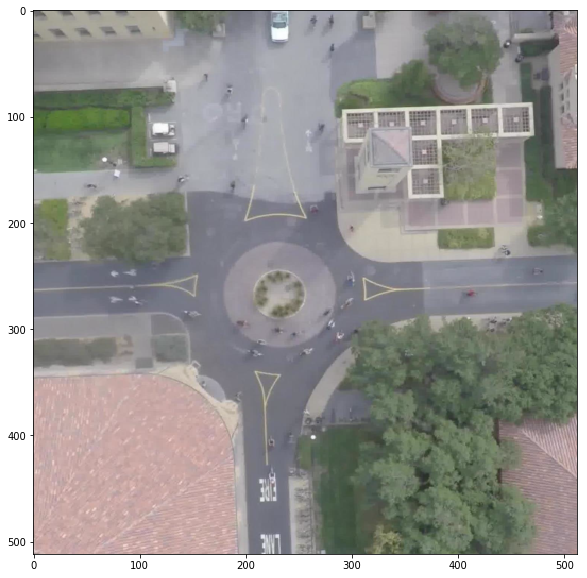

In [10]:
plt.figure(figsize=(10,10))
plt.imshow(x[0].permute(1,2,0).cpu().detach().numpy())
plt.clim(0,1)

0.0732924267578125

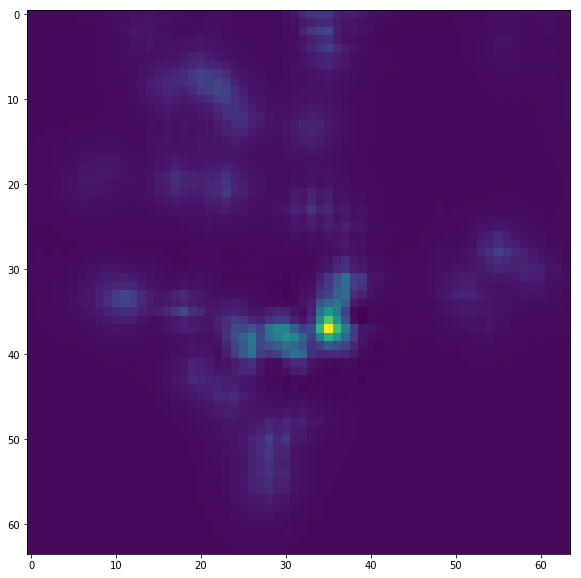

In [13]:
plt.figure(figsize=(10,10))
plt.imshow(output[0,0].cpu().detach().numpy())
np.sum(output[0,0].cpu().detach().numpy())*1e-5

In [9]:
dd = TestData()
DD = DataLoader(dataset = dd, num_workers = 1, batch_size = 1, shuffle = False)
model.eval()
for n_count, x in enumerate(DD):
    if n_count < 0:
        continue
    output = model(x.to(device))
    break

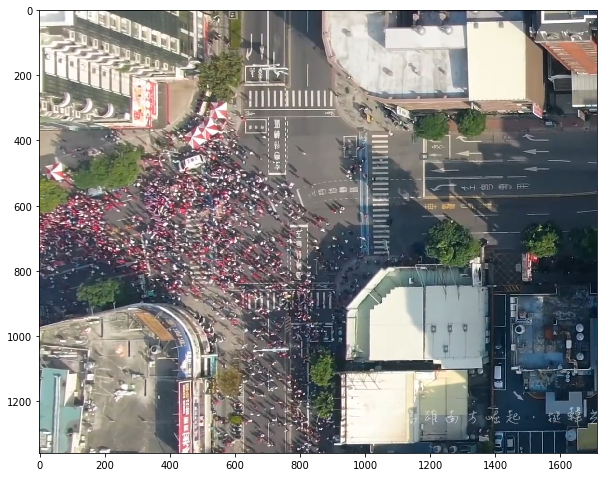

In [10]:
plt.figure(figsize=(10,10))
plt.imshow(x[0].permute(1,2,0).cpu().detach().numpy())
plt.clim(0,1)

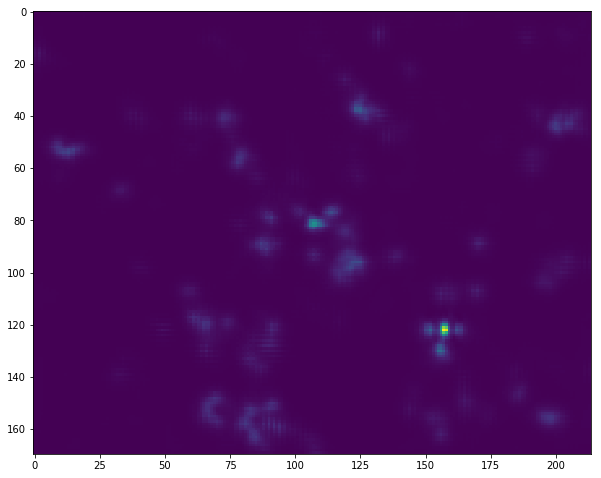

In [11]:
plt.figure(figsize=(10,10))
plt.imshow(output[0,0].cpu().detach().numpy())

In [12]:
for n_count, x in enumerate(DD):
    if n_count < 1:
        continue
    output = model(x.to(device))
    break

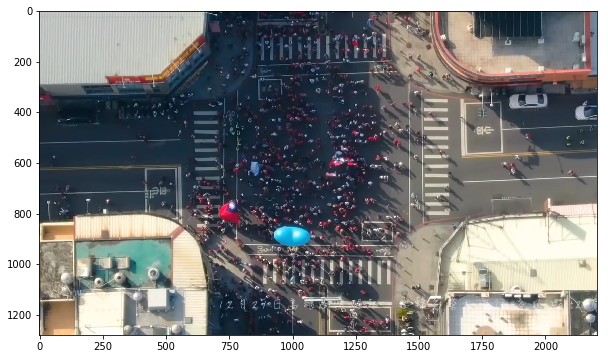

In [13]:
plt.figure(figsize=(10,10))
plt.imshow(x[0].permute(1,2,0).cpu().detach().numpy())
plt.clim(0,1)

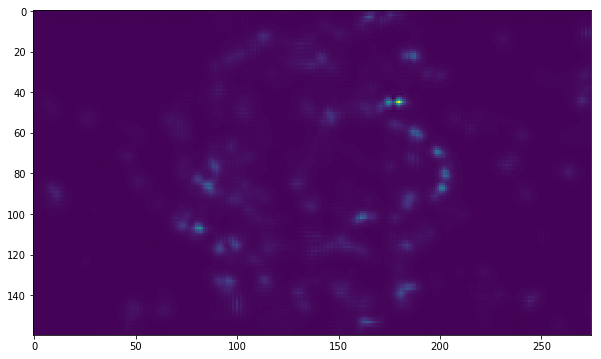

In [14]:
plt.figure(figsize=(10,10))
plt.imshow(output[0,0].cpu().detach().numpy())

# Backup

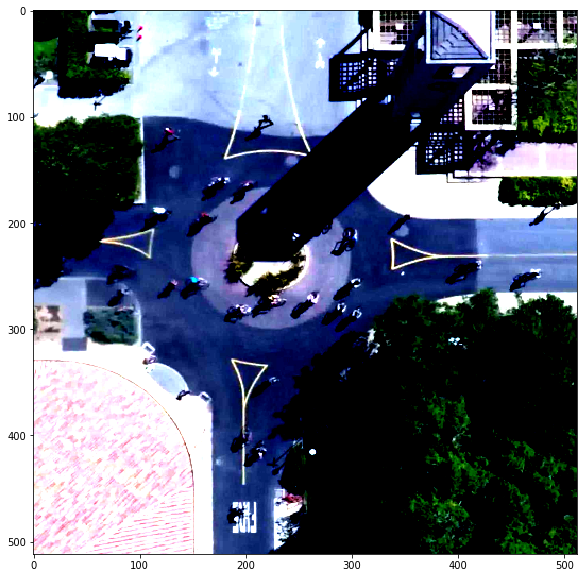

In [98]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.imshow(x[0].permute(1,2,0).numpy())
plt.clim(0,1)


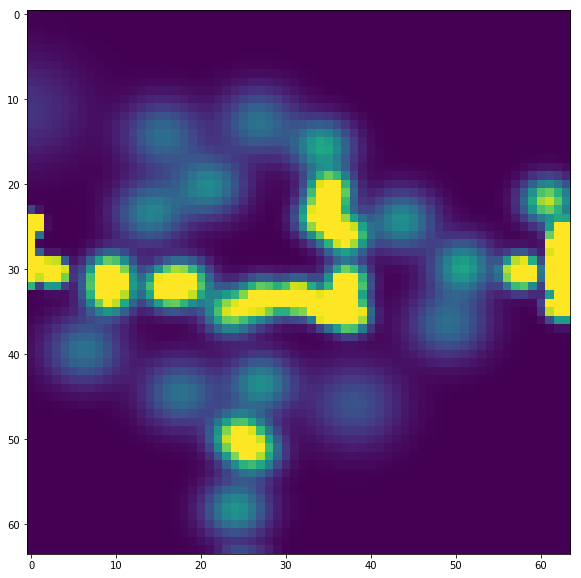

In [99]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.imshow(y[0,0,...].numpy()*10000)
plt.clim(0,1)